In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from matplotlib.colors import LinearSegmentedColormap


In [4]:
# the same as Garrett's data
df = pd.read_csv("./report_4_clean.csv")


<ipython-input-4-35a76c751c49>:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./report_4_clean.csv")


# Crashes Initial Daily Distribution

Firstly, we examine the hourly distribution of crashes. The polar plot indicates that crashes occur most frequently around 8 a.m. and between 12 p.m. and 6 p.m., with a pronounced peak from 3 p.m. to 5 p.m. 8 a.m. and peak time generally correspond to commuting hours, when traffic volume increases as people travel to and from work or school. This pattern suggests that higher roadway activity during rush hours may contribute to the elevated crash frequency. Next, we can further investigate whether this distribution exhibits a repeating daily pattern.

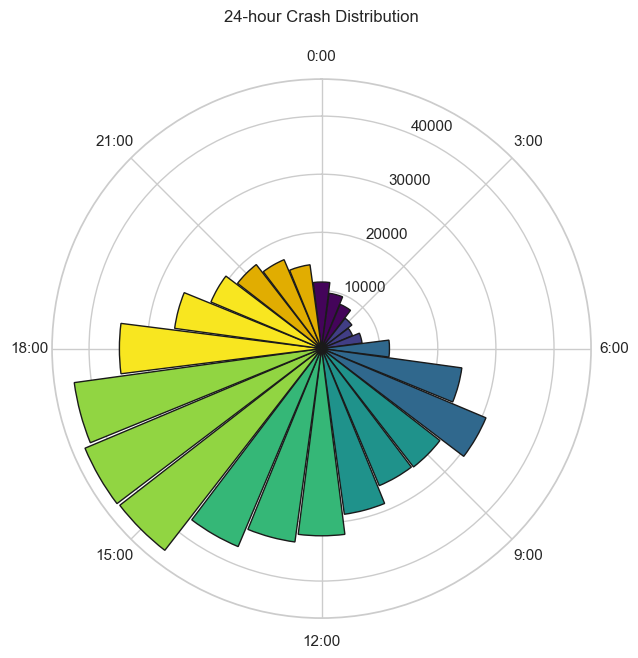

In [54]:
# --- Base data ---
hourly_counts = df['HOUR'].value_counts().sort_index()

angles = np.linspace(0, 2*np.pi, 24, endpoint=False)
values = hourly_counts.values

# --- No.017 color palette ---
no17_palette = ["#44045A", "#413E85", "#30688D", "#1F928B", "#35B777", "#91D542", "#F8E620", "#E1AD01"]

# assign color by 3-hour group
colors = [no17_palette[i // 3] for i in range(24)]

# --- Plot ---
fig, ax = plt.subplots(figsize=(7,7), subplot_kw={'projection':'polar'})
bars = ax.bar(angles, values, width=0.25, color=colors, edgecolor='k')

ax.set_xticks(np.linspace(0, 2*np.pi, 8, endpoint=False))
ax.set_xticklabels([f'{h}:00' for h in range(0, 24, 3)])

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

plt.title('24-hour Crash Distribution', pad=20)
plt.show()


We next explore the weekly data, as we predict that crashes may differ significantly between weekdays and weekends because of the presence or absence of commuting demands. The line plot clearly shows noticeable differences even without formal statistical tests.

On weekdays, crash frequency reaches a smaller peak around 8 a.m. and a bigger one between 4 p.m. and 5 p.m., corresponding to typical morning and evening rush hours. The crash line plots exhibit sharp increases and decreases, reflecting the concentrated traffic flow during commuting periods.

In contrast, the weekend pattern appears smoother. It gradually rising from around 6 a.m. and reaches a peak between 2 p.m. and 4 p.m. Overall, the average number of crashes on weekends is lower than that on weekdays.

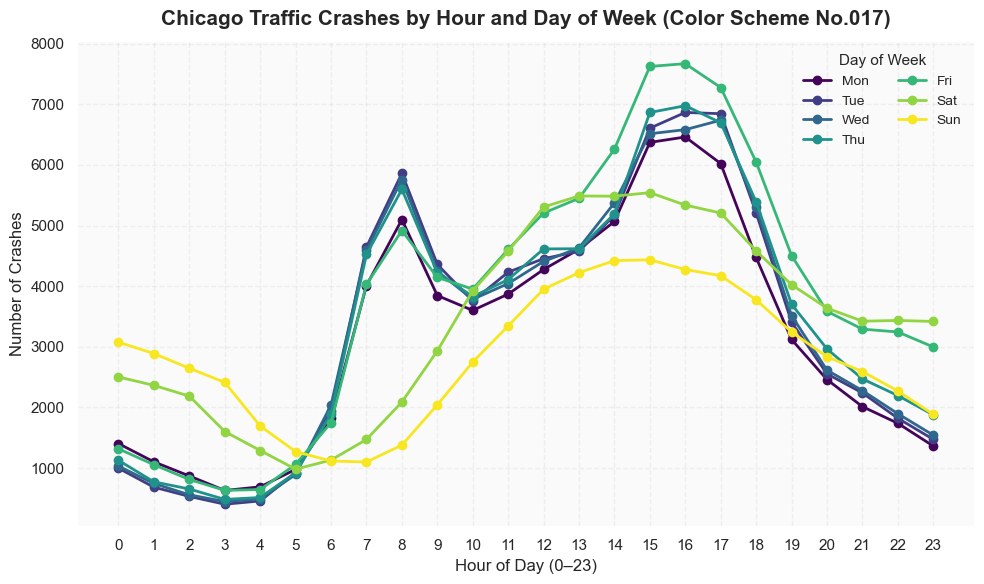

In [38]:
# Weekly

# No.017 
no017_palette = ["#44045A", "#413E85", "#30688D", "#1F928B", "#35B777", "#91D542", "#F8E620"]

sns.set_theme(style="whitegrid", rc={"axes.facecolor": "#fafafa"})
plt.figure(figsize=(10, 6))

day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for i, dow in enumerate(pivot.columns):
    plt.plot(
        pivot.index, pivot[dow],
        marker='o', linewidth=2,
        color=no017_palette[i],
        label=day_labels[dow - 1]
    )

plt.title("Chicago Traffic Crashes by Hour and Day of Week (Color Scheme No.017)",
          fontsize=15, weight='bold', pad=12)
plt.xlabel("Hour of Day (0–23)", fontsize=12)
plt.ylabel("Number of Crashes", fontsize=12)
plt.xticks(range(0, 24))
plt.legend(title="Day of Week", title_fontsize=11, fontsize=10,
           ncol=2, frameon=False, loc='upper right')
plt.grid(alpha=0.25, linestyle='--')
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


Finally, we can check the crash type to explore the reason of peak time. The dominant crash types during peak hours are rear-end, sideswipe same direction, and turning. These findings indicates that congestion and directional conflicts are the main contributors to peak-time accidents.

Besides, we also examine the frequency of crash types throughout the day on both weekdays and weekends. The bar plots show similar patterns to those observed in the peak hours, and the dominant causes of crashes remain same.

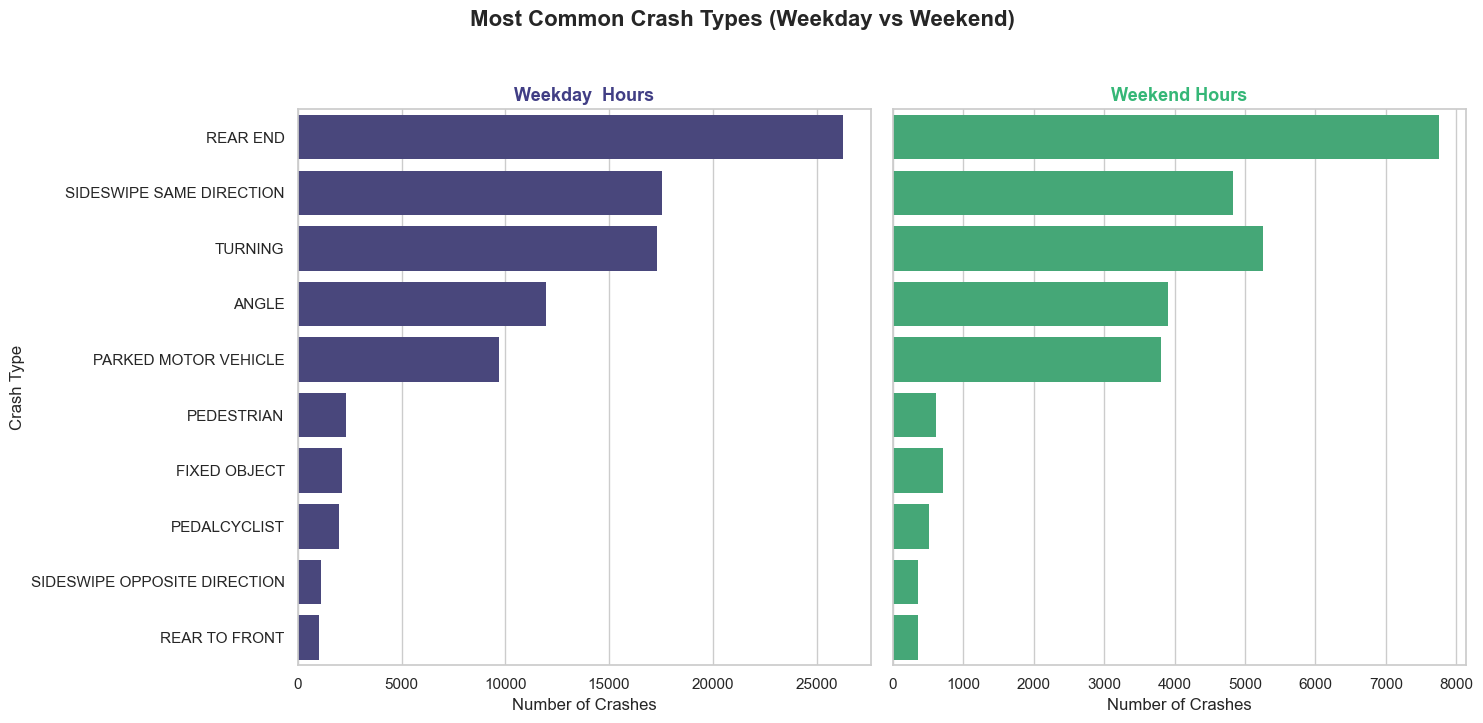

In [68]:
df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'], errors='coerce', infer_datetime_format=True)
df['HOUR'] = df['CRASH_DATE'].dt.hour
df['DAY_OF_WEEK'] = df['CRASH_DATE'].dt.dayofweek + 1  # Monday=1, Sunday=7

peak_weekends  = df[(df['HOUR'].isin([14,15,16])) & (df['DAY_OF_WEEK'].isin([6,7]))]
peak_weekdays = df[(df['HOUR'].isin([8,16,17])) & (df['DAY_OF_WEEK'].isin([1,2,3,4,5]))]

crash_type_weekends = (
    peak_weekends['FIRST_CRASH_TYPE']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'FIRST_CRASH_TYPE', 'FIRST_CRASH_TYPE': 'COUNT'})
)

crash_type_weekdays = (
    peak_weekdays['FIRST_CRASH_TYPE']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'FIRST_CRASH_TYPE', 'FIRST_CRASH_TYPE': 'COUNT'})
)

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)

color_weekday = "#413E85"   
color_weekend = "#35B777"  

sns.barplot(
    data=crash_type_weekdays.head(10),
    y='FIRST_CRASH_TYPE',
    x='COUNT',
    ax=axes[0],
    color=color_weekday,
    edgecolor='none'
)
axes[0].set_title('Weekday  Hours', fontsize=13, weight='bold', color=color_weekday)
axes[0].set_xlabel('Number of Crashes')
axes[0].set_ylabel('Crash Type')

sns.barplot(
    data=crash_type_weekends.head(10),
    y='FIRST_CRASH_TYPE',
    x='COUNT',
    ax=axes[1],
    color=color_weekend,
    edgecolor='none'
)
axes[1].set_title('Weekend Hours', fontsize=13, weight='bold', color=color_weekend)
axes[1].set_xlabel('Number of Crashes')
axes[1].set_ylabel('')

plt.suptitle('Most Common Crash Types (Weekday vs Weekend)',
             fontsize=16, weight='bold', y=1.03)
plt.tight_layout()
plt.show()


# Primary Causes

In [21]:
# standardize primary and secondary causes
df["PRIM_CONTRIBUTORY_CAUSE"] = df["PRIM_CONTRIBUTORY_CAUSE"].astype(str).str.upper()
df["SEC_CONTRIBUTORY_CAUSE"] = df["SEC_CONTRIBUTORY_CAUSE"].astype(str).str.upper()

# list of unknown conditions
unknowns = ["UNKNOWN", "UNABLE TO DETERMINE", "NOT APPLICABLE", "NAN", "", np.nan]

# shift instances where primary causes is an unknown condition, but secondary cause is present
mask = df["PRIM_CONTRIBUTORY_CAUSE"].isin(unknowns)
df.loc[mask, "PRIM_CONTRIBUTORY_CAUSE"] = df.loc[mask, "SEC_CONTRIBUTORY_CAUSE"]

df = df[
    (~df["PRIM_CONTRIBUTORY_CAUSE"].isin(unknowns))
].copy()

In [22]:
cause_mapping = {
    # 1.Sinage error

    "FAILING TO YIELD RIGHT-OF-WAY": "Ignoring Sign / Right-of-Way",
    "DISREGARDING STOP SIGN": "Ignoring Sign / Right-of-Way",
    "DISREGARDING YIELD SIGN": "Ignoring Sign / Right-of-Way",
    "DISREGARDING TRAFFIC SIGNALS": "Ignoring Sign / Right-of-Way",
    "DISREGARDING OTHER TRAFFIC SIGNS": "Ignoring Sign / Right-of-Way",
    "DISREGARDING ROAD MARKINGS": "Ignoring Sign / Right-of-Way",
    "TURNING RIGHT ON RED": "Ignoring Sign / Right-of-Way",

    # Manuever Error
    "IMPROPER BACKING": "Maneuvering",
    "IMPROPER LANE USAGE": "Maneuvering",
    "IMPROPER OVERTAKING/PASSING": "Maneuvering",
    "IMPROPER TURNING/NO SIGNAL": "Maneuvering",
    "DRIVING ON WRONG SIDE/WRONG WAY": "Maneuvering",

    # Aggressive
    "OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER": "Reckless",
    "PASSING STOPPED SCHOOL BUS": "Reckless",
    "DRIVING SKILLS/KNOWLEDGE/EXPERIENCE": "Reckless",
    "FOLLOWING TOO CLOSELY": "Reckless",

    # 2. Speed-Related
    "EXCEEDING AUTHORIZED SPEED LIMIT": "Speed Related",
    "EXCEEDING SAFE SPEED FOR CONDITIONS": "Speed Related",
    "FAILING TO REDUCE SPEED TO AVOID CRASH": "Speed Related",

    # 3. Impairment / Physical Condition
    "HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)": "Driver Impairment",
    "UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)": "Driver Impairment",
    "PHYSICAL CONDITION OF DRIVER": "Driver Impairment",

    # 4. Distraction
    "DISTRACTION - FROM INSIDE VEHICLE": "Distracted Driver",
    "DISTRACTION - FROM OUTSIDE VEHICLE": "Distracted Driver",
    "DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)": "Distracted Driver",
    "CELL PHONE USE OTHER THAN TEXTING": "Distracted Driver",
    "TEXTING": "Distracted Driver",

    # 5. Environmental / Roadway Conditions
    "WEATHER": "Environment / Road Conditions",
    "ROAD ENGINEERING/SURFACE/MARKING DEFECTS": "Environment / Road Conditions",
    "ROAD CONSTRUCTION/MAINTENANCE": "Environment / Road Conditions",
    "OBSTRUCTED CROSSWALKS": "Environment / Road Conditions",
    "RELATED TO BUS STOP": "Environment / Road Conditions",
    "VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)": "Environment / Road Conditions",
    "ANIMAL": "Environment / Road Conditions",
    "EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST": "Environment / Road Conditions",

    # 6. Vehicle-Related
    "EQUIPMENT - VEHICLE CONDITION": "Vehicle Malfunction",

    # Struck Bike
    "BICYCLE ADVANCING LEGALLY ON RED LIGHT": "Struck Legally Proceeding Bike",
    "MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT": "Struck Legally Proceeding Bike",
    
    # 7. Other / Unknown / Not Applicable
    "UNABLE TO DETERMINE": "Unknown",
    "NOT APPLICABLE": "Unknown",
    
}

cause_mapping_upper = {k.upper(): v for k, v in cause_mapping.items()}

# map primary causes to their groups
df["PRIM_CAUSE_GROUP"] = df["PRIM_CONTRIBUTORY_CAUSE"].map(cause_mapping_upper)
df["SEC_CAUSE_GROUP"] = df["SEC_CONTRIBUTORY_CAUSE"].map(cause_mapping_upper)

In [23]:
list(df["PRIM_CAUSE_GROUP"].unique())

['Maneuvering',
 'Ignoring Sign / Right-of-Way',
 'Driver Impairment',
 'Reckless',
 'Speed Related',
 'Environment / Road Conditions',
 'Vehicle Malfunction',
 'Distracted Driver',
 'Struck Legally Proceeding Bike']

In [12]:
df_filtered = df.copy()

# replace unknown conditions in primary and secondary causes as nan
df_filtered[["PRIM_CONTRIBUTORY_CAUSE", "SEC_CONTRIBUTORY_CAUSE"]] = (
    df_filtered[["PRIM_CONTRIBUTORY_CAUSE", "SEC_CONTRIBUTORY_CAUSE"]]
    .replace(unknowns, np.nan)
)

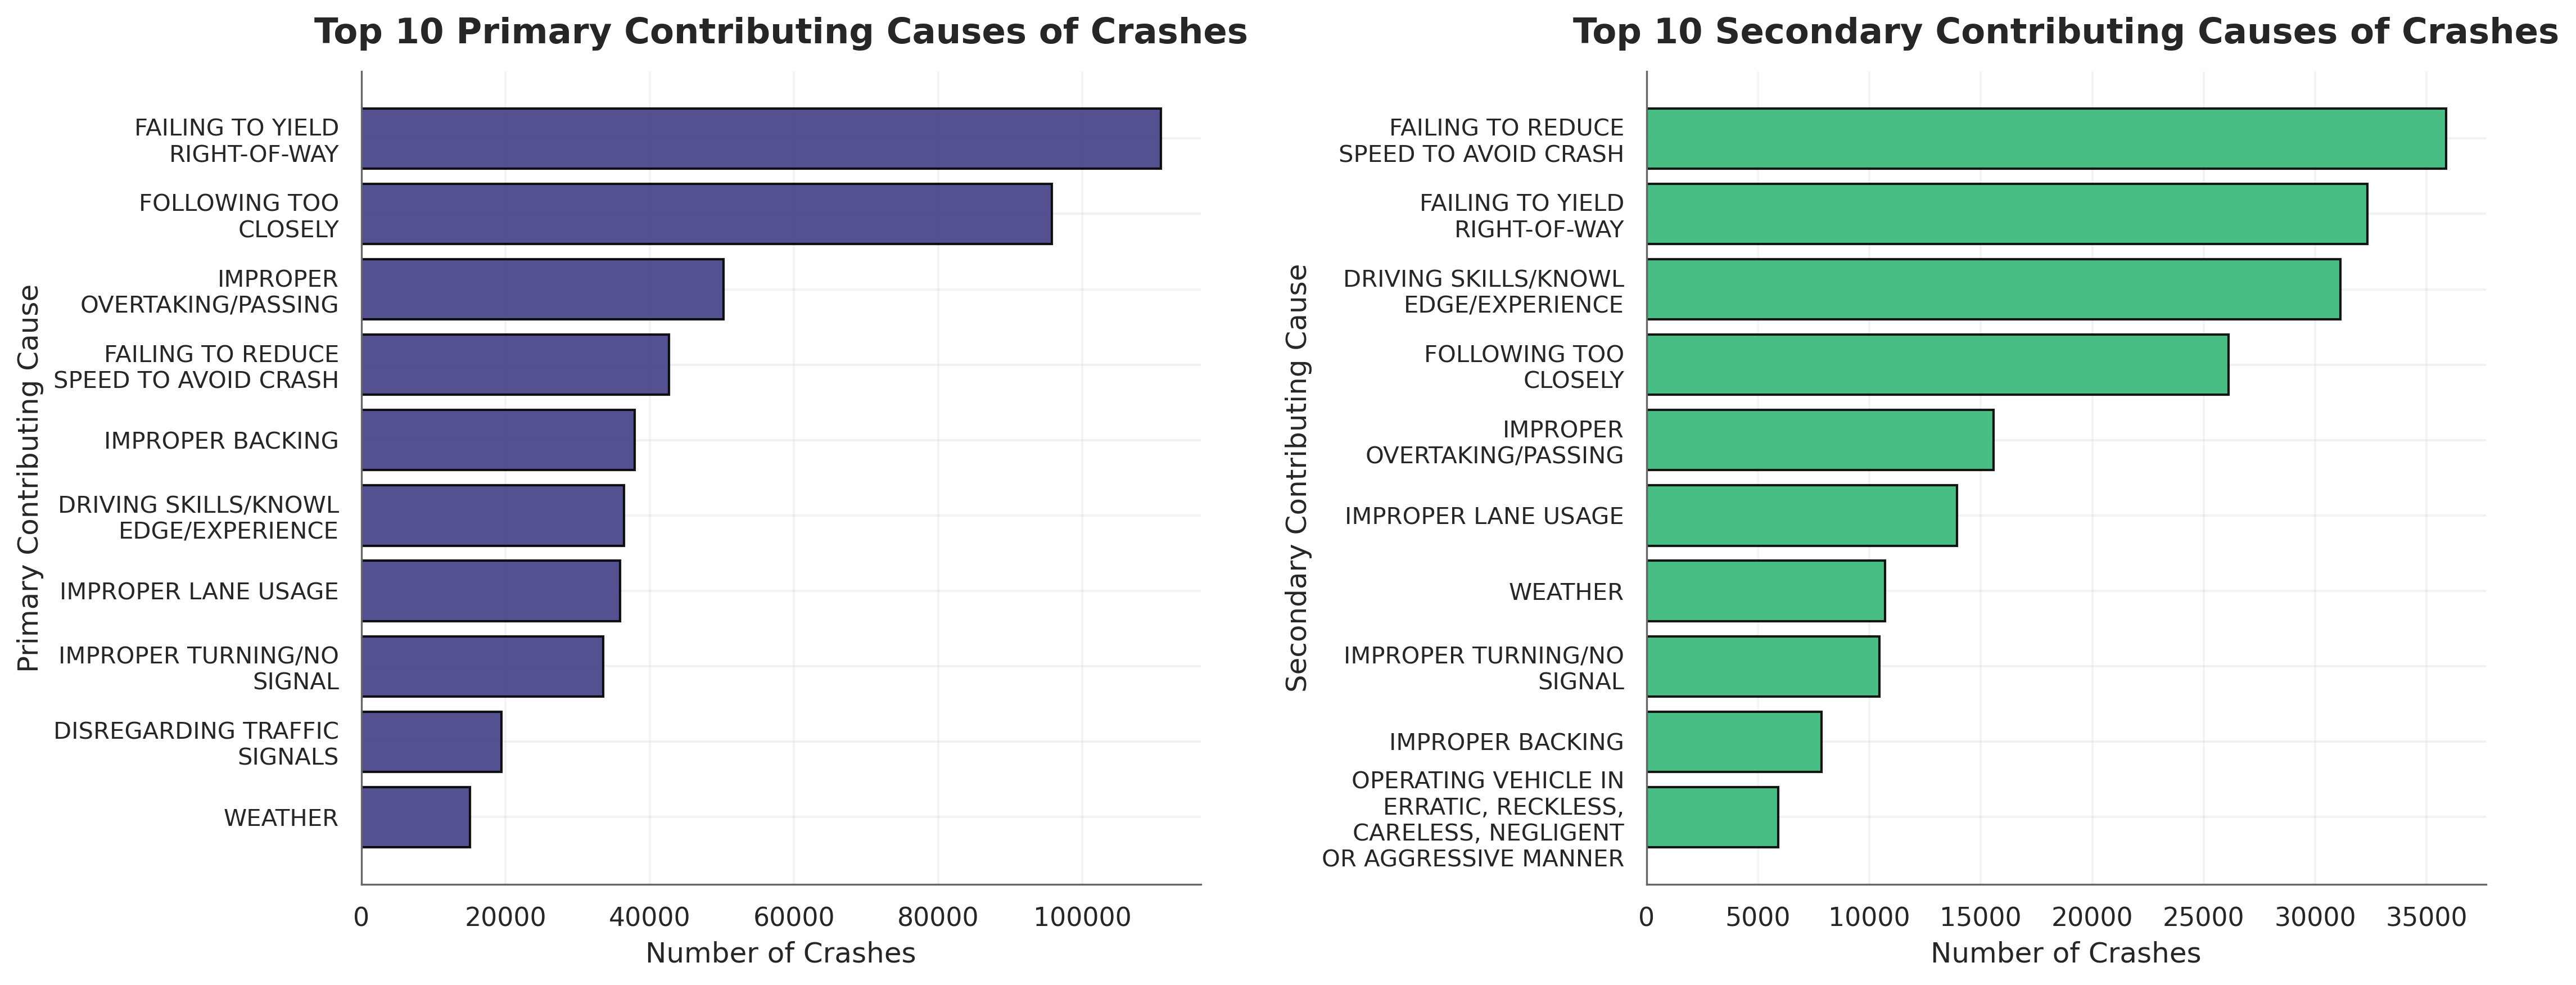

In [20]:
import textwrap
sns.set_theme(style="whitegrid", font="DejaVu Sans", rc={
    "axes.edgecolor": "0.4",
    "axes.linewidth": 0.8,
    "grid.alpha": 0.25,
    "axes.labelsize": 12,
    "axes.titlesize": 15,
    "xtick.labelsize": 11,
    "ytick.labelsize": 10,
})

primary_color = "#413E85"
secondary_color = "#35B777"

def wrap_labels(labels, width=20):
    return ['\n'.join(textwrap.wrap(l, width)) for l in labels]

top_primary = (
    df_filtered["PRIM_CONTRIBUTORY_CAUSE"]
    .value_counts()
    .head(10)
    .sort_values(ascending=True)
)
top_secondary = (
    df_filtered["SEC_CONTRIBUTORY_CAUSE"]
    .value_counts()
    .head(10)
    .sort_values(ascending=True)
)

fig, axes = plt.subplots(1, 2, figsize=(15, 6), dpi=300)

axes[0].barh(wrap_labels(top_primary.index), top_primary.values,
             color=primary_color, edgecolor="black", alpha=0.9)
axes[0].set_title("Top 10 Primary Contributing Causes of Crashes", fontweight="bold", pad=12)
axes[0].set_xlabel("Number of Crashes")
axes[0].set_ylabel("Primary Contributing Cause")
axes[0].grid(axis="x", alpha=0.2)

axes[1].barh(wrap_labels(top_secondary.index), top_secondary.values,
             color=secondary_color, edgecolor="black", alpha=0.9)
axes[1].set_title("Top 10 Secondary Contributing Causes of Crashes",
                  fontweight="bold", pad=12)
axes[1].set_xlabel("Number of Crashes")
axes[1].set_ylabel("Secondary Contributing Cause")
axes[1].grid(axis="x", alpha=0.2)

for ax in axes:
    ax.spines[['top','right']].set_visible(False)
    ax.set_facecolor("white")

plt.tight_layout(w_pad=3)
plt.show()


# patterns shifts since 2015


## hourly distribution pattern

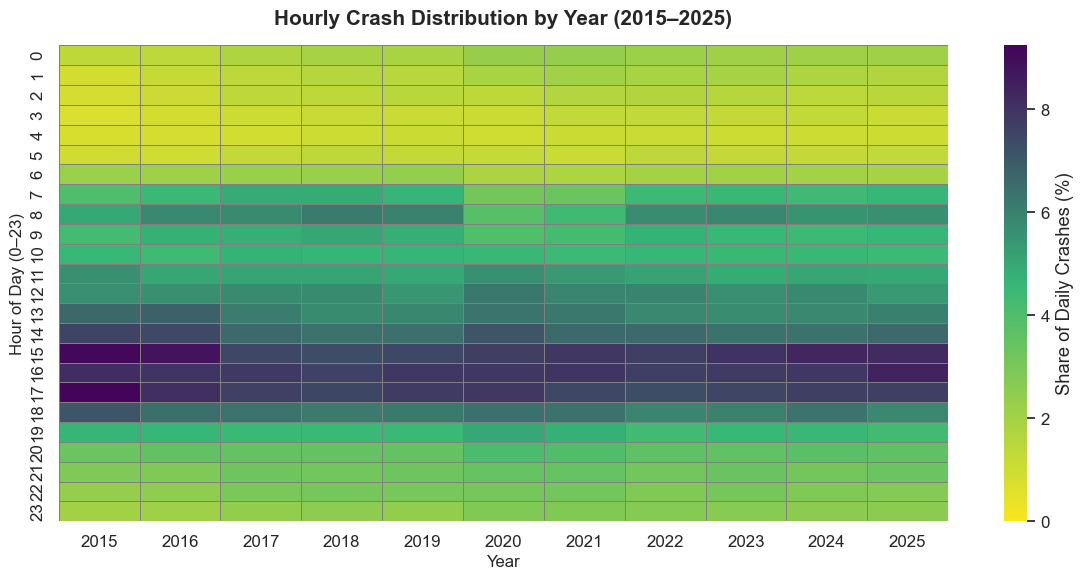

In [37]:


df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'], errors='coerce')
df['HOUR'] = df['CRASH_DATE'].dt.hour
df['YEAR'] = df['CRASH_DATE'].dt.year

hour_year = (
    df[df['YEAR'] >= 2015]
    .groupby(['YEAR', 'HOUR'])
    .size()
    .reset_index(name='COUNT')
)
hour_year['PERCENT'] = hour_year.groupby('YEAR')['COUNT'].apply(lambda x: x / x.sum() * 100)

pivot = hour_year.pivot(index='HOUR', columns='YEAR', values='PERCENT')


cmap = LinearSegmentedColormap.from_list(
    "traffic_contrast", ["#F8E620", "#35B777", "#44045A"]
)

plt.figure(figsize=(12, 6))
sns.heatmap(
    pivot,
    cmap=cmap,
    linewidths=0.4,
    linecolor='gray',
    vmin=0,
    vmax=pivot.max().max(),
    cbar_kws={'label': 'Share of Daily Crashes (%)'}
)
plt.title("Hourly Crash Distribution by Year (2015–2025)",
          fontsize=15, weight='bold', pad=15)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Hour of Day (0–23)", fontsize=12)
plt.tight_layout()
plt.show()


## primary cause pattern

In this part, we first compute the annual percentiles of each primary contributory cause, followed by averaging them over the past decade to choose the top 5 dominant causes. They are Failing to Reduce Speed to Avoid a Crash, Failing to Yield Right-of-Way, Following Too Closely, Improper Backing, and Improper Overtaking/Passing.

Then, we fit the Mixed Linear Model to see whether share of major crash causes shifts from 2015 to 2025.
By treating year as a continuous predictor, the model estimates the annual rate of change in cause proportions and tests whether these changes are statistically significant. This provides a rigorous measure of long-term shifts rather than relying on descriptive comparisons alone.

Besides, this model also introduces the random effects to account for repeated yearly observations within each crash cause and heterogeneity(different cause occupies different percentiles) in baseline prevalence.

In [6]:
df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'], errors='coerce')
df = df.dropna(subset=['CRASH_DATE'])
df['YEAR'] = df['CRASH_DATE'].dt.year

df = df[df['YEAR'] >= 2015]

df['PRIM_CONTRIBUTORY_CAUSE'] = df['PRIM_CONTRIBUTORY_CAUSE'].str.strip().str.upper()
exclude = ['UNABLE TO DETERMINE', 'NOT APPLICABLE', 'OTHER']
df = df[~df['PRIM_CONTRIBUTORY_CAUSE'].isin(exclude)]

In [7]:
df.head(5)

,Unnamed: 0.1,Unnamed: 0,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,...,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,HOUR,DAY_OF_WEEK,PRIM_CAUSE_GROUP,SEC_CAUSE_GROUP,YEAR
0,0,1589,9f054420d1c4bc029c5910568517a48b7dc9d7555ed200...,NaN,2025-09-30 23:53:00,30,TRAFFIC SIGNAL,UNKNOWN,CLEAR,"DARKNESS, LIGHTED ROAD",...,3,9,41.857483,-87.643652,POINT (-87.643651940728 41.857482677485),23,2,Maneuvering,Maneuvering,2025
1,1,1590,f92b8cc3174c550697b8f9908c1767bc431f9fefd84c02...,NaN,2025-09-30 23:39:00,30,FLASHING CONTROL SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",...,3,9,41.888925,-87.644259,POINT (-87.644259085327 41.88892450931),23,2,Ignoring Sign / Right-of-Way,Unknown,2025
2,2,1591,e5ec75cefc457dedb14f56cc04e92ef76920f0bee9b822...,NaN,2025-09-30 23:38:00,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",...,3,9,41.897965,-87.677258,POINT (-87.677258067246 41.897964577589),23,2,Driver Impairment,Driver Impairment,2025
3,4,1593,56c0435e3d5231a5cb532b53f6e3f5bd1c3dc890962d99...,NaN,2025-09-30 23:14:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",...,3,9,41.894758,-87.624101,POINT (-87.624100573673 41.894758464564),23,2,Maneuvering,Maneuvering,2025
4,5,1594,98bc4ac2fb0e6021edfba37a4c41c8ebb27178a949993f...,NaN,2025-09-30 23:08:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",...,3,9,41.707117,-87.623668,POINT (-87.6236676203 41.707116579239),23,2,Maneuvering,Maneuvering,2025


In [8]:
cause_year = (
    df.groupby(['YEAR', 'PRIM_CAUSE_GROUP'])
      .size()
      .reset_index(name='COUNT')
)

cause_year['PERCENT'] = (
    cause_year.groupby('YEAR')['COUNT']
    .transform(lambda x: x / x.sum() * 100)
)


In [19]:
causegroupall = (
    cause_year.groupby('PRIM_CAUSE_GROUP')['PERCENT']
    .mean()
    .sort_values(ascending=False)
    .index
)

top5 = (
    cause_year.groupby('PRIM_CAUSE_GROUP')['PERCENT']
    .mean()
    .sort_values(ascending=False)
    .head(5)
    .index
)


cause_top5 = cause_year[cause_year['PRIM_CAUSE_GROUP'].isin(top5)]
cause_all = cause_year[cause_year['PRIM_CAUSE_GROUP'].isin(causegroupall)]

In [21]:
cause_all['PRIM_CAUSE_GROUP'].unique()

array(['Distracted Driver', 'Driver Impairment',
       'Environment / Road Conditions', 'Ignoring Sign / Right-of-Way',
       'Maneuvering', 'Reckless', 'Speed Related',
       'Struck Legally Proceeding Bike', 'Vehicle Malfunction'],
      dtype=object)

In [20]:
cause_top5['PRIM_CAUSE_GROUP'].unique()

array(['Environment / Road Conditions', 'Ignoring Sign / Right-of-Way',
       'Maneuvering', 'Reckless', 'Speed Related'], dtype=object)

<ipython-input-23-1e010b110d75>:5: UserWarning: 
The palette list has fewer values (7) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=cause_all, x='YEAR', y='PERCENT',


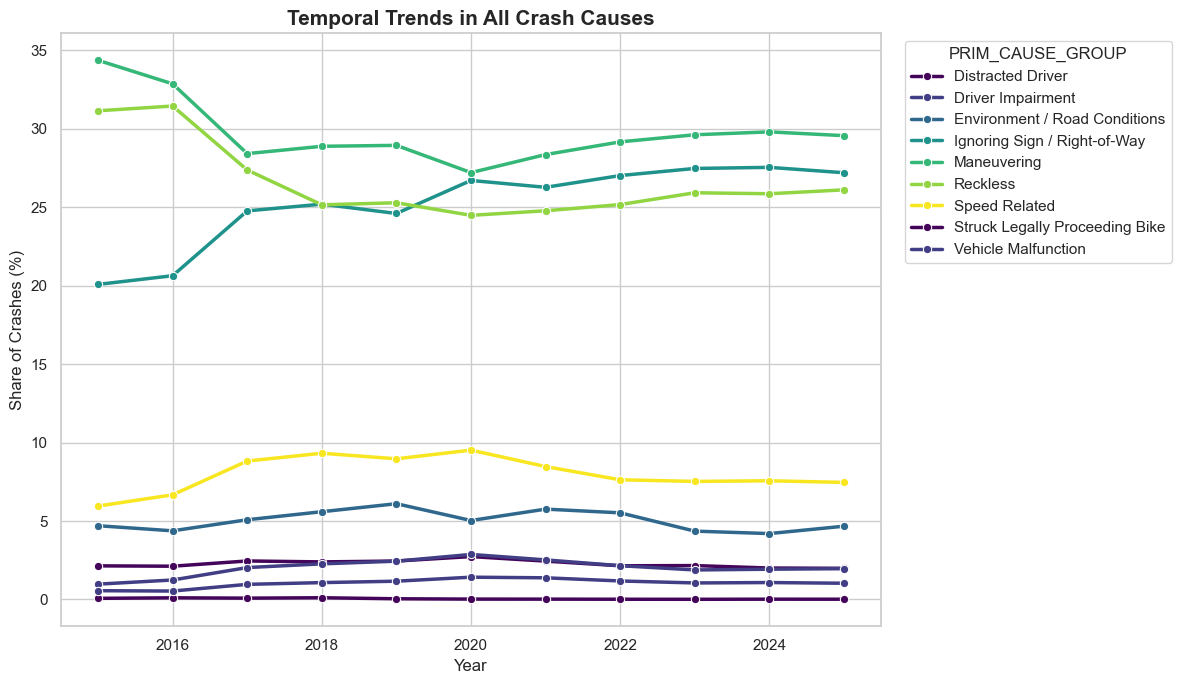

In [23]:
no017 = ["#44045A","#413E85","#30688D","#1F928B","#35B777","#91D542","#F8E620"]

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12,7))
sns.lineplot(data=cause_all, x='YEAR', y='PERCENT',
             hue='PRIM_CAUSE_GROUP', palette=no017,
             linewidth=2.5, marker='o')
plt.title('Temporal Trends in All Crash Causes',
          fontsize=15, weight='bold')
plt.xlabel('Year')
plt.ylabel('Share of Crashes (%)')
plt.legend(title='PRIM_CAUSE_GROUP', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

In [24]:
model_mixed2 = smf.mixedlm(
    "PERCENT ~ YEAR * PRIM_CAUSE_GROUP",
    data=cause_top5,
    groups=cause_top5["PRIM_CAUSE_GROUP"]
).fit()



/Users/sunday/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Before analyzing the shifts or changes, we first do diagnostic checks for our model.

<ipython-input-26-c63987dd1db8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cause_top5['FITTED'] = model_mixed2.fittedvalues
<ipython-input-26-c63987dd1db8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cause_top5['RESID'] = model_mixed2.resid
<ipython-input-26-c63987dd1db8>:15: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.scatterplot(
/Users/sunday/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: col

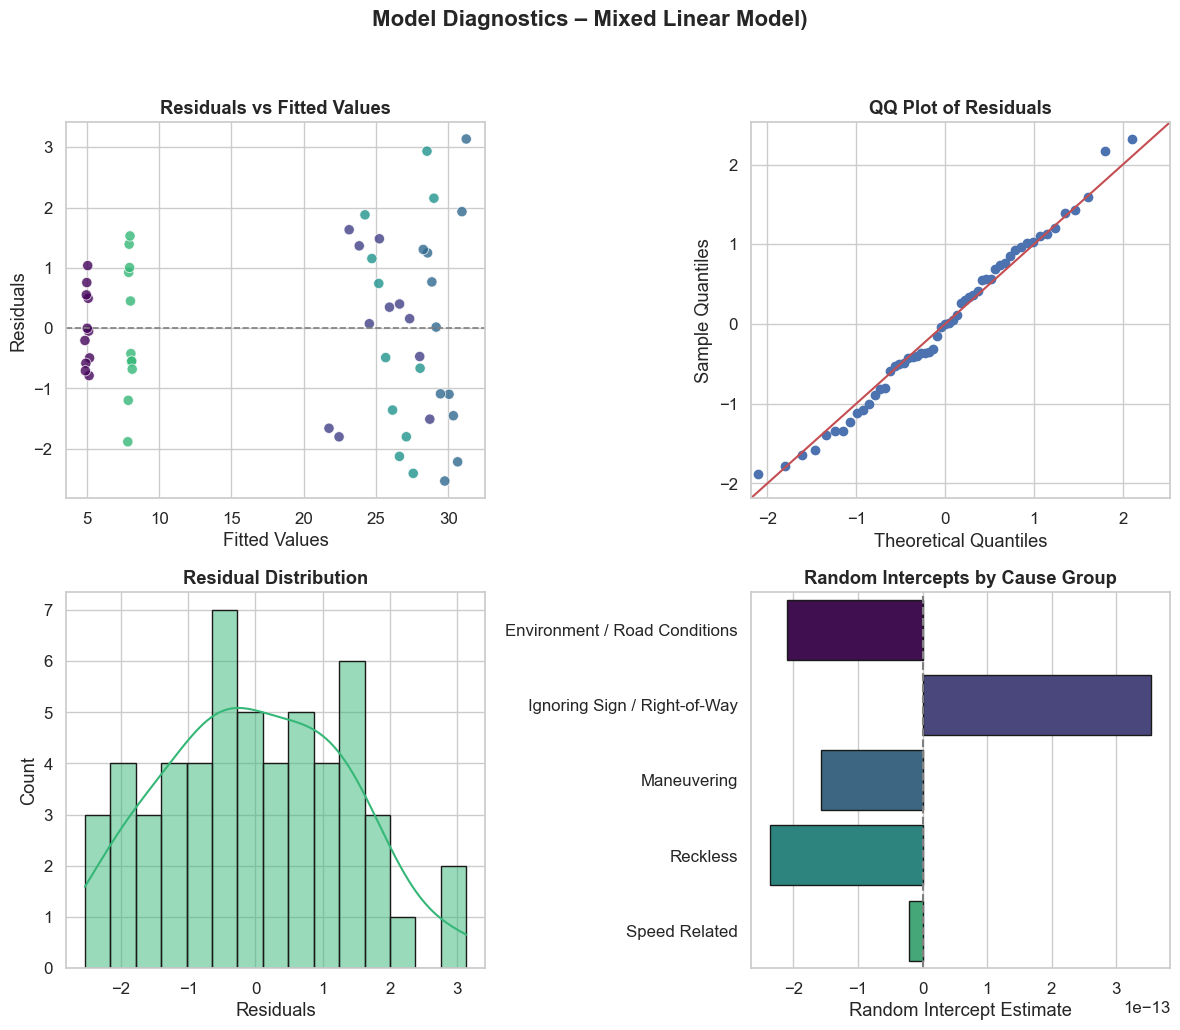

In [26]:
cause_top5['FITTED'] = model_mixed2.fittedvalues
cause_top5['RESID'] = model_mixed2.resid

ranef = model_mixed2.random_effects
ranef_df = pd.DataFrame([(k, v[0]) for k, v in ranef.items()],
                        columns=['PRIM_CAUSE_GROUP', 'Random_Intercept'])

# No.017 
no017 = ["#44045A","#413E85","#30688D","#1F928B","#35B777","#91D542","#F8E620"]

sns.set_theme(style="whitegrid", font_scale=1.1)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.35, wspace=0.25)

sns.scatterplot(
    data=cause_top5, x='FITTED', y='RESID',
    hue='PRIM_CAUSE_GROUP', palette=no017, s=55, alpha=0.8, ax=axes[0,0], legend=False
)
axes[0,0].axhline(0, color='gray', linestyle='--', lw=1.2)
axes[0,0].set_title("Residuals vs Fitted Values", weight='bold')
axes[0,0].set_xlabel("Fitted Values")
axes[0,0].set_ylabel("Residuals")

sm.qqplot(cause_top5['RESID'], line='45', fit=True, ax=axes[0,1], color="#1F928B")
axes[0,1].set_title("QQ Plot of Residuals", weight='bold')

sns.histplot(cause_top5['RESID'], kde=True, color="#35B777", bins=15, edgecolor='k', ax=axes[1,0])
axes[1,0].set_title("Residual Distribution", weight='bold')
axes[1,0].set_xlabel("Residuals")
axes[1,0].set_ylabel("Count")

sns.barplot(data=ranef_df, x='Random_Intercept', y='PRIM_CAUSE_GROUP',
            palette=no017, edgecolor='k', ax=axes[1,1])
axes[1,1].axvline(0, color='gray', linestyle='--')
axes[1,1].set_title("Random Intercepts by Cause Group", weight='bold')
axes[1,1].set_xlabel("Random Intercept Estimate")
axes[1,1].set_ylabel("")

fig.suptitle("Model Diagnostics – Mixed Linear Model)", fontsize=16, weight='bold', y=1.03)
plt.tight_layout()
plt.show()


The residual–fitted plot shows no discernible nonlinear pattern, indicating linearity and homoscedasticity.

The QQ plot indicate approximate normality, validating the model’s error assumptions.

The residual distribution indicates that residuals are approximately centered and symmetric around zero, indicating a well-fitted and unbiased model.

Random intercept estimates display limited variation among crash causes, indicating that most of the explained variance arises from fixed temporal effects rather than group-level deviations.

Overall, the diagnostics confirm that the mixed model is valid and reliable. 

In [27]:
print(model_mixed2.summary())

                                 Mixed Linear Model Regression Results
Model:                              MixedLM                 Dependent Variable:                 PERCENT 
No. Observations:                   55                      Method:                             REML    
No. Groups:                         5                       Scale:                              2.2257  
Min. group size:                    11                      Log-Likelihood:                     -99.5996
Max. group size:                    11                      Converged:                          Yes     
Mean group size:                    11.0                                                                
--------------------------------------------------------------------------------------------------------
                                                        Coef.   Std.Err.   z    P>|z|   [0.025   0.975] 
-----------------------------------------------------------------------------------------

Scale(Group variance) is 2.23, which indicates moderate heterogeneity and is captured by the random intercepts.

Significant varibles includes Ignoring Sign / Right-of-Way, Reckless, YEAR:Ignoring Sign / Right-of-Way and  YEAR:Reckless. The proportions of crashes caused by Ignoring Sign / Right-of-Way, Reckless have significantly increased by 0.7% and decreased 0.4% per year respectively while other causes show no significant temporal shift.
